# **Data Reading & Sampling**

In [1]:
!pip install imbalanced-learn==0.7.0


In [2]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Data Handling & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Handling Imbalanced Data
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning Models
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Pipeline
from sklearn.pipeline import make_pipeline

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')


**Undersampling** is a technique used to address class imbalance in a dataset, commonly employed when the proportion between classes is significantly skewed. 

In the context of financial transactions where only a **small portion** is flagged as **money laundering**, undersampling involves reducing the abundance of the majority class (non-money laundering transactions) to match the quantity of the minority class (money laundering transactions). This process randomly selects and removes instances from the majority class until a balanced representation between both classes is achieved. By doing so, it ensures that the model is trained on a more proportionate dataset, mitigating the impact of class imbalance and improving the model's ability to accurately learn and predict across both classes.

In [4]:
chunk_size = 100000
rus = RandomUnderSampler(random_state=42)
undersampled_data = pd.DataFrame()

for chunk in pd.read_csv(r"archive (3)/HI-Large_Trans.csv", chunksize=chunk_size):
    X_chunk = chunk.drop('Is Laundering', axis=1)
    y_chunk = chunk['Is Laundering']
    
    if len(y_chunk.unique()) > 1:
        X_rus, y_rus = rus.fit_resample(X_chunk, y_chunk)
        chunk_rus = pd.concat([X_rus, y_rus], axis=1)
        undersampled_data = pd.concat([undersampled_data, chunk_rus], ignore_index=True)


In [5]:
df = undersampled_data

In [6]:
df.to_csv('HI-Large_Trans_Sampled.csv', index=False)

In [8]:
df = pd.read_csv("HI-Large_Trans_Sampled.csv")

# **Data Understanding**

In [9]:
df.head(10)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/08/01 00:11,36738,8033CC480,36738,8033CC480,3282.69,US Dollar,3282.69,US Dollar,Reinvestment,0
1,2022/08/01 00:19,70,100428660,8381,8035B3E00,27815.14,US Dollar,27815.14,US Dollar,Cheque,1
2,2022/08/01 00:17,27076,814F9F6E0,27076,814F9F6E0,207177.21,US Dollar,207177.21,US Dollar,Reinvestment,0
3,2022/08/01 00:16,347207,812A8DFA0,347207,812A8DFA0,1479.74,US Dollar,1479.74,US Dollar,Reinvestment,0
4,2022/08/01 00:04,21710,80789D110,42935,811EEF2A0,151.27,US Dollar,151.27,US Dollar,Credit Card,0
5,2022/08/01 00:24,221413,809BA19E0,15027,8104F8A40,2496.59,US Dollar,2496.59,US Dollar,Cash,0
6,2022/08/01 00:13,32425,80FC90C90,32425,80FC90C90,6.68,US Dollar,6.68,US Dollar,Reinvestment,0
7,2022/08/01 00:07,10542,80EAEAE10,10542,80EAEAE10,1466123.41,US Dollar,1466123.41,US Dollar,Reinvestment,0
8,2022/08/01 00:28,70,100428660,29630,814B11040,86532.59,US Dollar,86532.59,US Dollar,Cheque,1
9,2022/08/01 00:06,215275,816439360,235985,816439870,4163.80,US Dollar,4163.80,US Dollar,ACH,1


In [10]:
df.shape

(451092, 11)

In [11]:
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

In [12]:
df.columns = [col.replace(' ', '_').replace('.', '_').lower() for col in df.columns]
df.columns

Index(['timestamp', 'from_bank', 'account', 'to_bank', 'account_1',
       'amount_received', 'receiving_currency', 'amount_paid',
       'payment_currency', 'payment_format', 'is_laundering'],
      dtype='object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451092 entries, 0 to 451091
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   timestamp           451092 non-null  object 
 1   from_bank           451092 non-null  int64  
 2   account             451092 non-null  object 
 3   to_bank             451092 non-null  int64  
 4   account_1           451092 non-null  object 
 5   amount_received     451092 non-null  float64
 6   receiving_currency  451092 non-null  object 
 7   amount_paid         451092 non-null  float64
 8   payment_currency    451092 non-null  object 
 9   payment_format      451092 non-null  object 
 10  is_laundering       451092 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 37.9+ MB


In [14]:
df.isnull().sum()

timestamp             0
from_bank             0
account               0
to_bank               0
account_1             0
amount_received       0
receiving_currency    0
amount_paid           0
payment_currency      0
payment_format        0
is_laundering         0
dtype: int64

In [15]:
df['is_laundering'].value_counts()

0    225546
1    225546
Name: is_laundering, dtype: int64

Displaying an example of money laundering occurrence: **[is_laundering] = 1**

In [16]:
df_laundering = df[df['is_laundering'] == 1]
df_laundering.head(10)

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
1,2022/08/01 00:19,70,100428660,8381,8035B3E00,27815.14,US Dollar,27815.14,US Dollar,Cheque,1
8,2022/08/01 00:28,70,100428660,29630,814B11040,86532.59,US Dollar,86532.59,US Dollar,Cheque,1
9,2022/08/01 00:06,215275,816439360,235985,816439870,4163.80,US Dollar,4163.80,US Dollar,ACH,1
10,2022/08/01 00:05,70,100428660,220255,818305750,10111.03,US Dollar,10111.03,US Dollar,Cheque,1
11,2022/08/01 00:16,70,100428660,1922,8192DF510,162.16,US Dollar,162.16,US Dollar,Cash,1
12,2022/08/01 00:08,70,100428660,253568,819B9C7A0,13785.54,US Dollar,13785.54,US Dollar,Cash,1
13,2022/08/01 00:10,70,100428660,167996,81C0AA460,20918.99,US Dollar,20918.99,US Dollar,Cheque,1
38,2022/08/01 00:26,70,100428660,273388,82290C460,10541.83,US Dollar,10541.83,US Dollar,Cheque,1
39,2022/08/09 05:14,952,8139F54E0,111632,8062C56E0,5331.44,US Dollar,5331.44,US Dollar,ACH,1
40,2022/08/13 13:09,111632,8062C56E0,8456,81363F620,5602.59,US Dollar,5602.59,US Dollar,ACH,1


In [17]:
different_amounts = df[df['amount_received'] != df['amount_paid']]
different_amounts.head(100)

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
225,2022/08/01 01:23,118247,80D272AB0,118247,80D272AB0,251.83,US Dollar,1686.64,Yuan,ACH,0
254,2022/08/01 00:30,294136,82300BC40,294136,82300BC40,4504452.82,Australian Dollar,2468394.23,UK Pound,ACH,0
338,2022/08/01 01:33,24583,803067A10,24583,803067A10,1929.27,Euro,2260.69,US Dollar,ACH,0
428,2022/08/01 02:15,11520,806D96280,11520,806D96280,34456.50,US Dollar,29405.17,Euro,ACH,0
476,2022/08/01 02:16,16327,8029BB5B0,16327,8029BB5B0,381.76,Canadian Dollar,289.37,US Dollar,ACH,0
...,...,...,...,...,...,...,...,...,...,...,...
14728,2022/08/04 09:46,15325,82BC16F00,15325,82BC16F00,6144.63,Euro,7200.17,US Dollar,ACH,0
14934,2022/08/04 11:02,39447,81041D480,39447,81041D480,2603.50,US Dollar,17437.23,Yuan,ACH,0
14962,2022/08/04 11:12,115474,80BAF56E0,115474,80BAF56E0,342432.63,Brazil Real,60645.11,US Dollar,ACH,0
14987,2022/08/04 10:52,37262,8187DC350,37262,8187DC350,175.17,Euro,205.26,US Dollar,ACH,0


As it turns out, the divergence in values between **[amount_received]** and **[amount_paid]** is attributed to the discrepancy in **[receiving_currency]** and **[payment_currency]**. Additionally, a majority of transactions utilize the **'ACH'** payment format.

In [18]:
same_currency = (df['amount_received'] != df['amount_paid']) & (df['receiving_currency'] == df['payment_currency'])
same_currency.value_counts()

False    451092
dtype: int64

We also found out that there are no transactions that have different **[amount_received]** and **[amount_paid]** while the **[receiving_currency]** and **[payment_currency]** is the same.

In [19]:
df['payment_format'].value_counts()

ACH             228268
Cheque          105256
Credit Card      72493
Cash             27553
Wire              8460
Bitcoin           6742
Reinvestment      2320
Name: payment_format, dtype: int64

In [20]:
df_laundering['payment_format'].value_counts()

ACH            199164
Cheque          13260
Credit Card      7846
Cash             3663
Bitcoin          1608
Wire                5
Name: payment_format, dtype: int64

**Money laundering** tends to occur when utilizing the [payment_format] **ACH (Automated Clearing House)**: an electronic payment method enabling fund transfers between banks electronically, commonly used for routine payments such as monthly bill payments.

In [21]:
df['payment_currency'].value_counts()

US Dollar            173041
Euro                 114091
Yuan                  33700
UK Pound              17718
Ruble                 16110
Shekel                14656
Yen                   13401
Australian Dollar     11751
Canadian Dollar       11144
Rupee                 10552
Swiss Franc            8387
Mexican Peso           8069
Bitcoin                6740
Brazil Real            6278
Saudi Riyal            5454
Name: payment_currency, dtype: int64

In [22]:
df_laundering['payment_currency'].value_counts()

US Dollar            90439
Euro                 63086
Yuan                 17468
UK Pound             10221
Ruble                 9089
Yen                   7288
Rupee                 5249
Australian Dollar     5212
Shekel                4615
Canadian Dollar       3532
Swiss Franc           2326
Mexican Peso          2165
Brazil Real           1806
Bitcoin               1608
Saudi Riyal           1442
Name: payment_currency, dtype: int64

**Money laundering** tends to occur when utilizing [payment_currency] **US Dollar**.

In [23]:
df['receiving_currency'].value_counts()

US Dollar            172387
Euro                 114202
Yuan                  33395
UK Pound              17728
Ruble                 16223
Shekel                14799
Yen                   13432
Australian Dollar     11860
Canadian Dollar       11211
Rupee                 10581
Swiss Franc            8482
Mexican Peso           8144
Bitcoin                6797
Brazil Real            6343
Saudi Riyal            5508
Name: receiving_currency, dtype: int64

In [24]:
df_laundering['receiving_currency'].value_counts()

US Dollar            90439
Euro                 63086
Yuan                 17468
UK Pound             10221
Ruble                 9089
Yen                   7288
Rupee                 5249
Australian Dollar     5212
Shekel                4615
Canadian Dollar       3532
Swiss Franc           2326
Mexican Peso          2165
Brazil Real           1806
Bitcoin               1608
Saudi Riyal           1442
Name: receiving_currency, dtype: int64

The same trend is observed in [receiving_currency], where **Money laundering** tends to occur when using **US Dollar**.

# **Splitting the Data (Train & Test)**

In [25]:
input_df  = df.drop('is_laundering', axis = 1)
output_df = df['is_laundering']

In [26]:
x_train, x_test, y_train, y_test = train_test_split(input_df, output_df, test_size = 0.2, random_state = 42)

# **Exploratory Data Analysis**

### Numerical Data 

One of the key features of a **boxplot** is its ability to **highlight outliers**. These are data points that lie significantly **outside the interquartile range (IQR)**. In the context of **financial transactions**, outliers in the **amount_received** and **amount_paid** columns could **represent unusually large transactions** that might warrant further investigation, especially in a domain like **anti-money laundering.**

<AxesSubplot:xlabel='amount_received'>

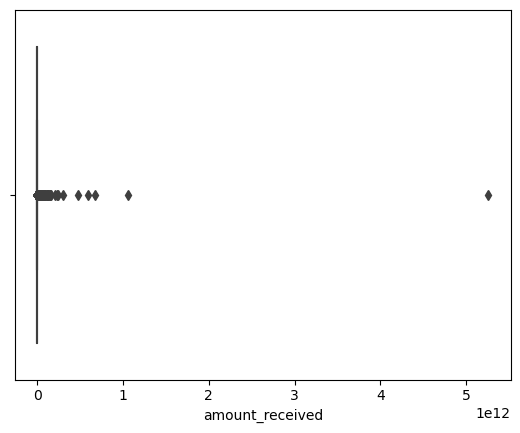

In [27]:
sns.boxplot(x= x_train['amount_received'])

In [28]:
q1 = x_train['amount_received'].quantile(0.25)
q3 = x_train['amount_received'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = (x_train['amount_received'] < lower_bound) | (x_train['amount_received'] > upper_bound)

In [29]:
num_outliers = outliers.sum()
percentage_outliers = (num_outliers / len(x_train)) * 100
print("Amount Received")
print(f"Number of outliers: {num_outliers}")
print(f"Percentage of outliers: {percentage_outliers}%")

Amount Received
Number of outliers: 55922
Percentage of outliers: 15.496310336323305%


<AxesSubplot:xlabel='amount_paid'>

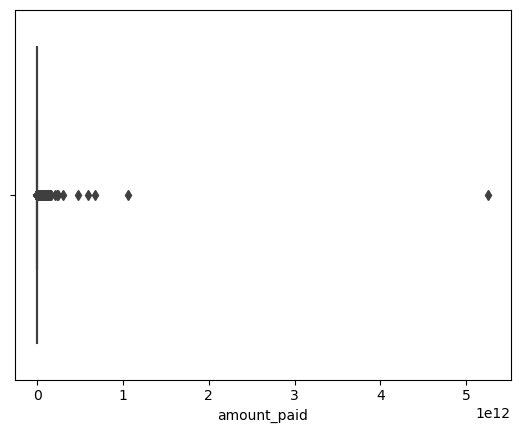

In [30]:
sns.boxplot(x=x_train['amount_paid'])

In [31]:
q1_paid = x_train['amount_paid'].quantile(0.25)
q3_paid = x_train['amount_paid'].quantile(0.75)
iqr_paid = q3_paid - q1_paid
lower_bound_paid = q1_paid - 1.5 * iqr_paid
upper_bound_paid = q3_paid + 1.5 * iqr_paid
outliers_paid = (x_train['amount_paid'] < lower_bound_paid) | (x_train['amount_paid'] > upper_bound_paid)

In [32]:
num_outliers_paid = outliers_paid.sum()
percentage_outliers_paid = (num_outliers_paid / len(x_train)) * 100
print("Amount Paid")
print(f"Number of outliers: {num_outliers_paid}")
print(f"Percentage of outliers: {percentage_outliers_paid}%")

Amount Paid
Number of outliers: 55756
Percentage of outliers: 15.450310774150463%


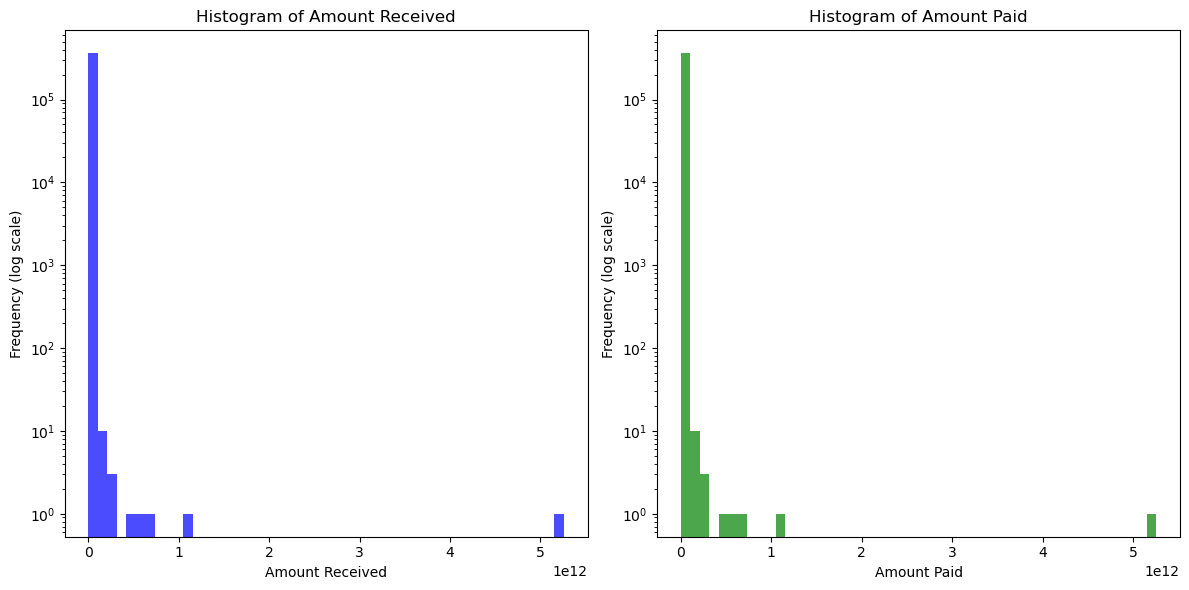

In [33]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_train['amount_received'], bins=50, color='blue', alpha=0.7, log=True)
plt.title('Histogram of Amount Received')
plt.xlabel('Amount Received')
plt.ylabel('Frequency (log scale)')

plt.subplot(1, 2, 2)
plt.hist(x_train['amount_paid'], bins=50, color='green', alpha=0.7, log=True)
plt.title('Histogram of Amount Paid')
plt.xlabel('Amount Paid')
plt.ylabel('Frequency (log scale)')

plt.tight_layout()
plt.show()

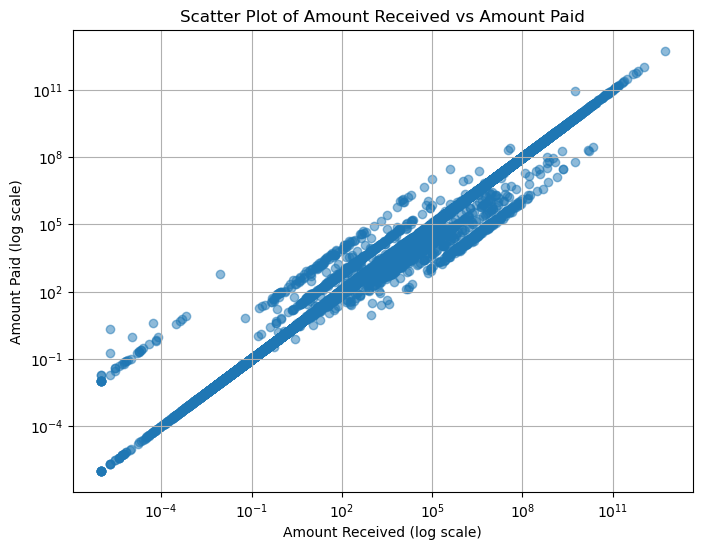

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train['amount_received'], x_train['amount_paid'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('Scatter Plot of Amount Received vs Amount Paid')
plt.xlabel('Amount Received (log scale)')
plt.ylabel('Amount Paid (log scale)')
plt.grid(True)
plt.show()

### Categorical Data 

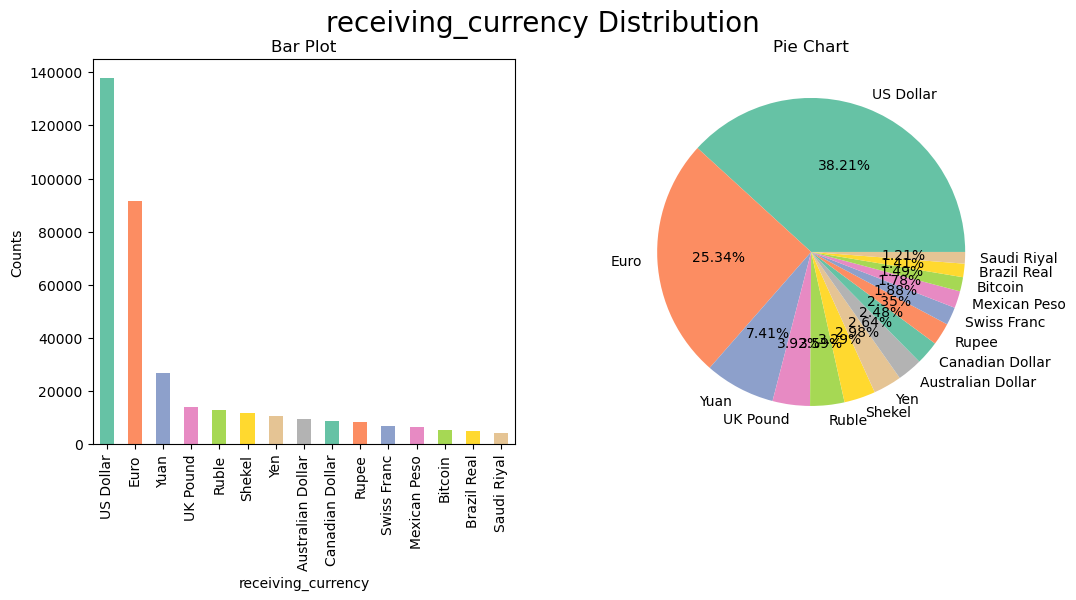

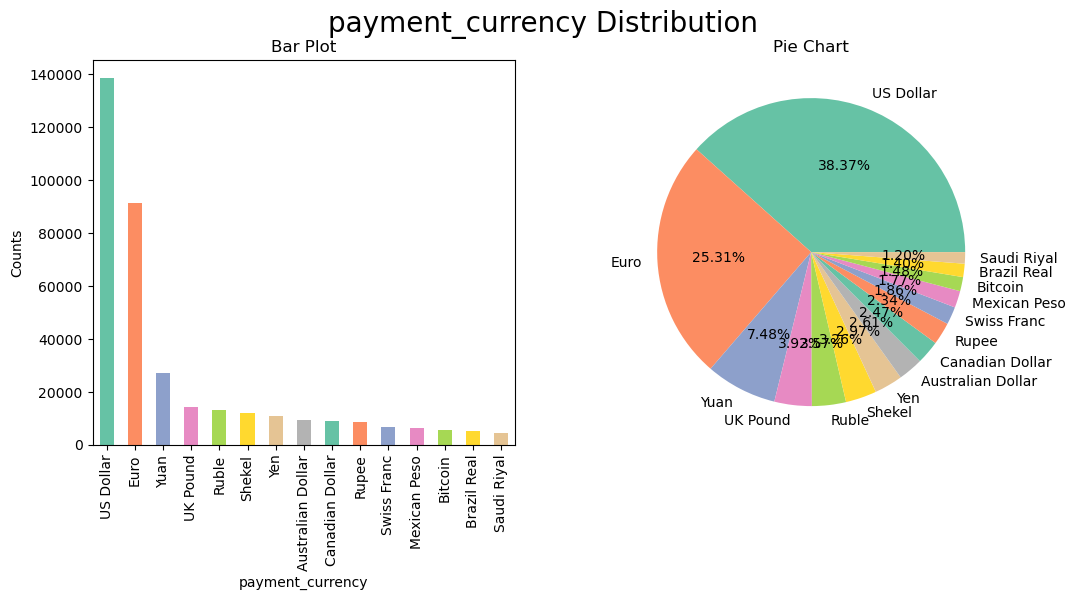

In [35]:
columns_to_plot = ['receiving_currency', 'payment_currency']
palette = sns.color_palette("Set2")

for column in columns_to_plot:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'{column} Distribution', fontsize=20)

    plt.subplot(1, 2, 1)
    x_train[column].value_counts().plot(kind='bar', color=palette)
    plt.title('Bar Plot')
    plt.xlabel(column)
    plt.ylabel('Counts')

    plt.subplot(1, 2, 2)
    x_train[column].value_counts().plot(kind='pie', autopct="%.2f%%", colors=palette)
    plt.title('Pie Chart')
    plt.ylabel('')

    plt.show()

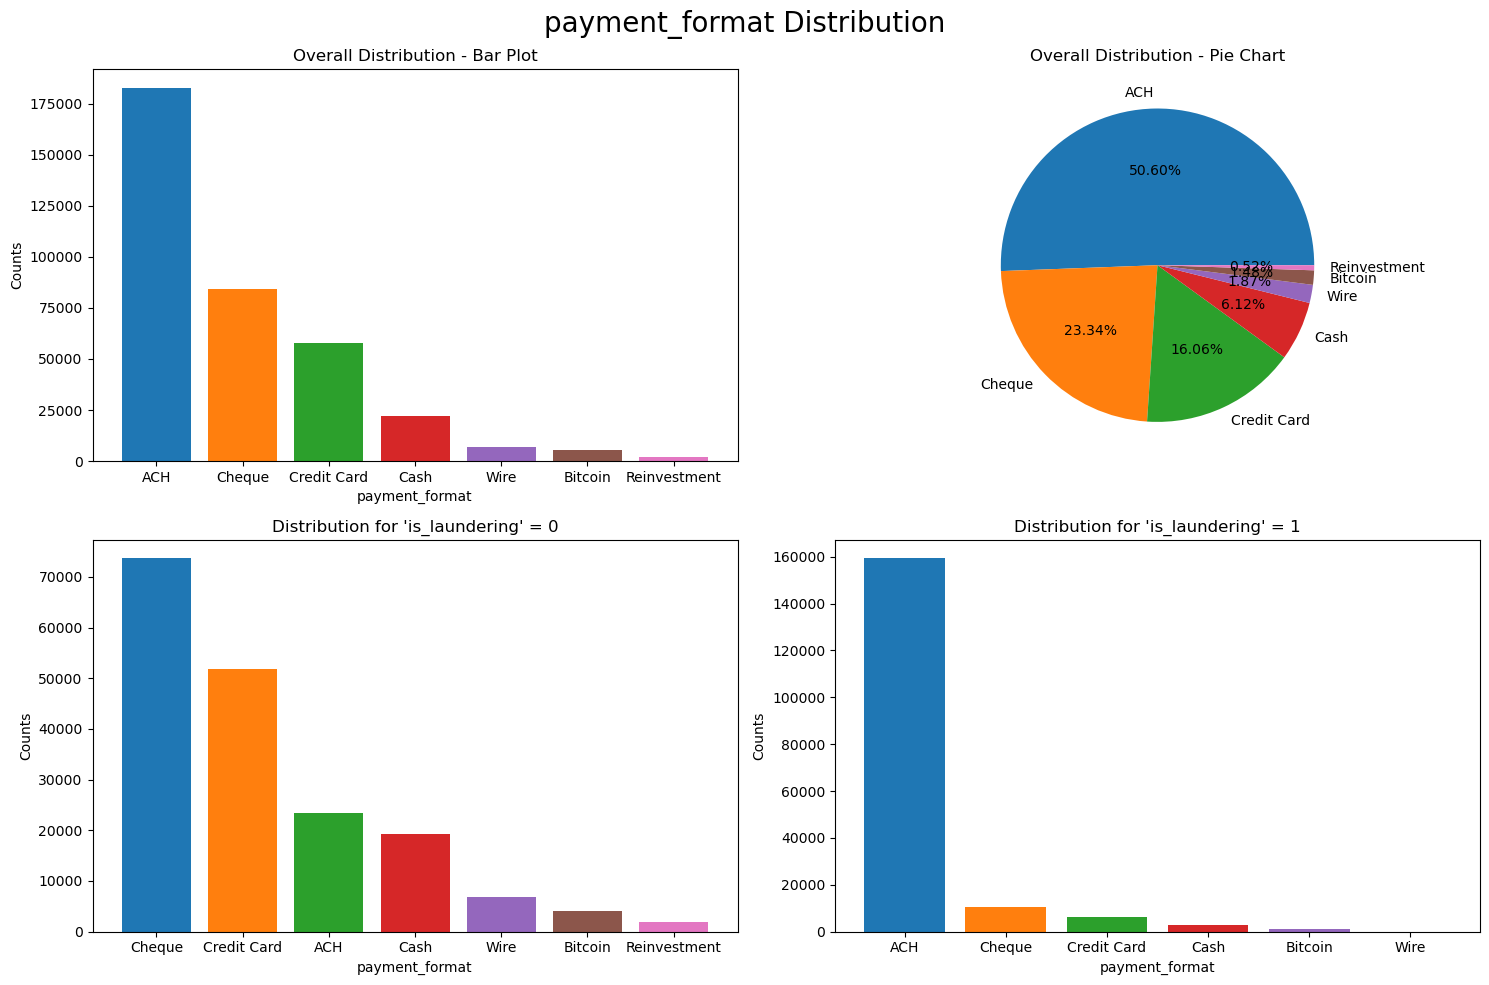

In [36]:
column = 'payment_format'
palette = sns.color_palette("tab10")

fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 
fig.suptitle(f'{column} Distribution', fontsize=20)

axs[0, 0].bar(x_train[column].value_counts().index, x_train[column].value_counts().values, color=palette)
axs[0, 0].set_title('Overall Distribution - Bar Plot')
axs[0, 0].set_xlabel(column)
axs[0, 0].set_ylabel('Counts')

axs[0, 1].pie(x_train[column].value_counts(), labels=x_train[column].value_counts().index, autopct="%.2f%%", colors=palette)
axs[0, 1].set_title('Overall Distribution - Pie Chart')

x_train_laundering_0 = x_train[y_train == 0]
axs[1, 0].bar(x_train_laundering_0[column].value_counts().index, x_train_laundering_0[column].value_counts().values, color=palette)
axs[1, 0].set_title("Distribution for 'is_laundering' = 0")
axs[1, 0].set_xlabel(column)
axs[1, 0].set_ylabel('Counts')

x_train_laundering_1 = x_train[y_train == 1]
axs[1, 1].bar(x_train_laundering_1[column].value_counts().index, x_train_laundering_1[column].value_counts().values, color=palette)
axs[1, 1].set_title("Distribution for 'is_laundering' = 1")
axs[1, 1].set_xlabel(column)
axs[1, 1].set_ylabel('Counts')

plt.tight_layout()
plt.show()

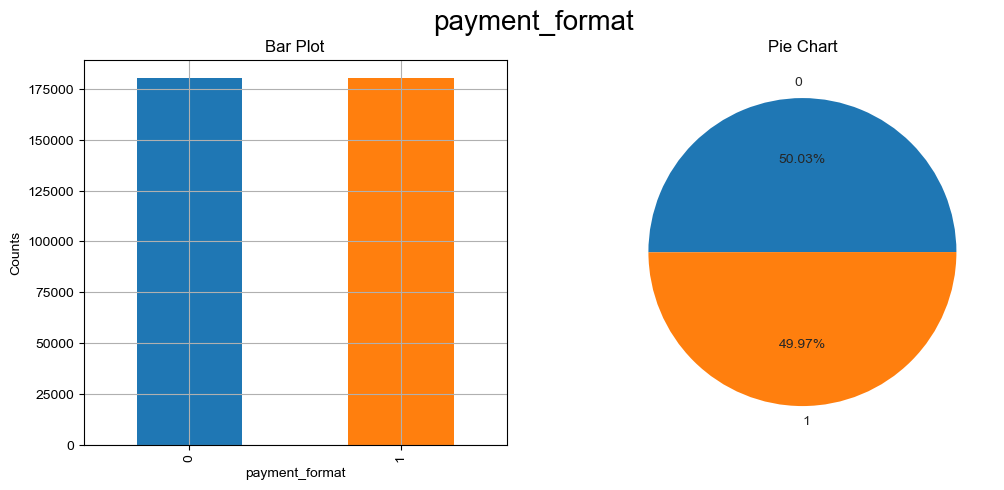

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'{column}', fontsize=20) 
plt.style.use('seaborn')

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color=sns.color_palette("tab10"))
plt.title('Bar Plot')
plt.xlabel(column)
plt.ylabel('Counts')

plt.subplot(1, 2, 2)
y_train.value_counts().plot(kind='pie', autopct="%.2f%%", colors=sns.color_palette("tab10"))
plt.title('Pie Chart')
plt.ylabel('')

plt.show()

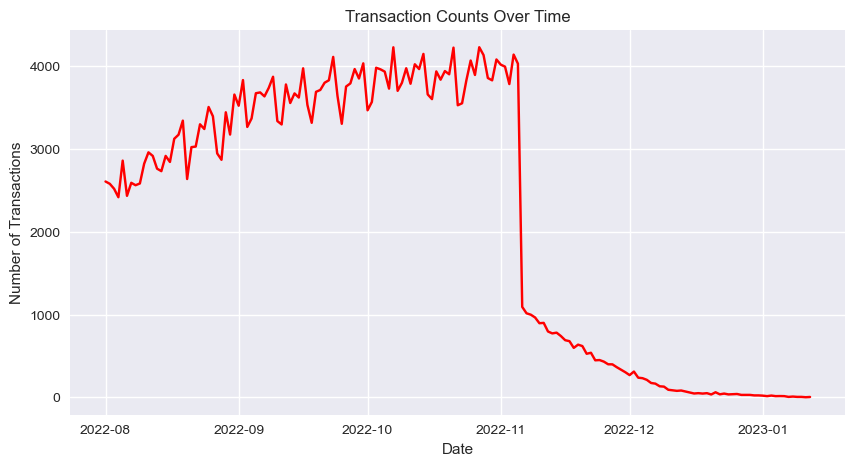

In [38]:
x_train['timestamp'] = pd.to_datetime(x_train['timestamp'], format='%Y/%m/%d %H:%M')

transactions_by_date = x_train['timestamp'].dt.date.value_counts().sort_index()

plt.figure(figsize=(10, 5))
transactions_by_date.plot(kind='line', color='red')
plt.title('Transaction Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

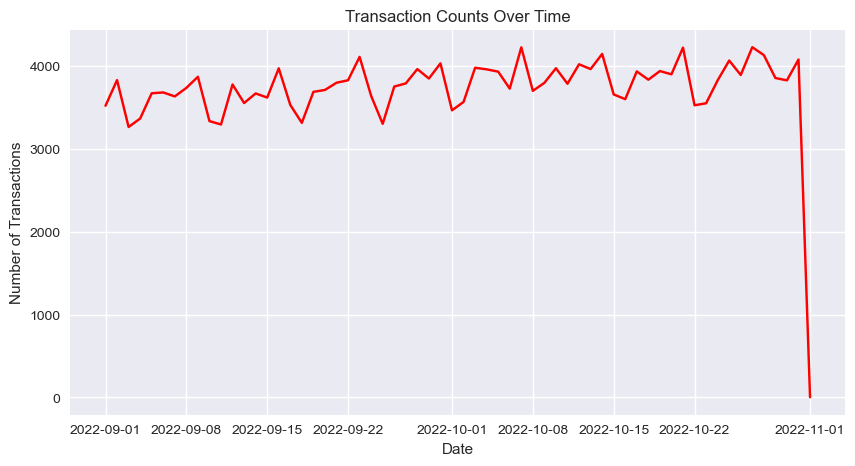

In [39]:
x_train['timestamp'] = pd.to_datetime(x_train['timestamp'], format='%Y/%m/%d %H:%M')

start_date = '2022-09-01'
end_date = '2022-11-01'
filtered_date = x_train[(x_train['timestamp'] >= start_date) & (x_train['timestamp'] <= end_date)]

transactions_by_date = filtered_date['timestamp'].dt.date.value_counts().sort_index()

plt.figure(figsize=(10, 5))
transactions_by_date.plot(kind='line', color='red')
plt.title('Transaction Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

# **Feature Engineering**

## **Feature Extraction**

In [40]:
x_train.head(10)

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format
55116,2022-08-13 15:51:00,112140,80D805990,227535,810EB00A0,761.09,US Dollar,761.09,US Dollar,Cheque
10084,2022-08-03 07:13:00,210789,808B20D10,140416,84EED9000,108.28,Euro,108.28,Euro,Credit Card
209295,2022-09-17 00:37:00,70,1004286A8,134945,837FB3960,51.46,Euro,51.46,Euro,Cheque
301866,2022-10-27 06:44:00,143079,8166DC0F0,58692,8157F4490,1391468.76,Yen,1391468.76,Yen,ACH
366094,2022-10-19 15:51:00,70,1004289C0,1187494,846DFFCE0,1968421.18,Shekel,1968421.18,Shekel,Cheque
374535,2022-10-21 09:39:00,261901,83CDFFD00,11853,84575AAF0,57.99,Euro,57.99,Euro,Cheque
173246,2022-09-18 12:07:00,118303,806E1B810,230636,80F5B1A20,15460.23,US Dollar,15460.23,US Dollar,ACH
404030,2022-10-27 15:32:00,231260,810B8E330,22112,81F4C1190,4665.41,Euro,4665.41,Euro,Cheque
54532,2022-08-13 11:16:00,250403,813022090,250403,8130C8C00,483216.42,Yen,483216.42,Yen,ACH
306772,2022-10-07 12:59:00,219767,8285459E0,31691,8307C3A60,152.07,Euro,152.07,Euro,Cheque


In [41]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360873 entries, 55116 to 121958
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           360873 non-null  datetime64[ns]
 1   from_bank           360873 non-null  int64         
 2   account             360873 non-null  object        
 3   to_bank             360873 non-null  int64         
 4   account_1           360873 non-null  object        
 5   amount_received     360873 non-null  float64       
 6   receiving_currency  360873 non-null  object        
 7   amount_paid         360873 non-null  float64       
 8   payment_currency    360873 non-null  object        
 9   payment_format      360873 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 30.3+ MB


In [42]:
x_train['timestamp'] = pd.to_datetime(x_train['timestamp'])
x_test['timestamp'] = pd.to_datetime(x_test['timestamp'])

In [43]:
x_train['year'] = x_train['timestamp'].dt.year
x_test['year'] = x_test['timestamp'].dt.year

min_year = x_train['year'].min()
max_year = x_train['year'].max()
print(min_year, max_year)

2022 2023


In [44]:
x_train['year'].value_counts()

2022    360746
2023       127
Name: year, dtype: int64

In [45]:
x_train[x_train['year'] == 2023].head()

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,year
436497,2023-01-06 14:29:00,1818,801C96840,12893,8011A4560,10438.45,Euro,10438.45,Euro,ACH,2023
415411,2023-01-03 14:52:00,115079,808746AB0,6521,80270D690,7266.22,Euro,7266.22,Euro,ACH,2023
442413,2023-01-05 11:25:00,235055,81C8A7C90,237304,80E474200,50560.66,Yuan,50560.66,Yuan,ACH,2023
415184,2023-01-01 10:19:00,94379,824911650,196972,824B511E0,8660.54,UK Pound,8660.54,UK Pound,ACH,2023
431207,2023-01-08 20:02:00,11,8013AD3A0,19326,81841EDB0,4538.35,US Dollar,4538.35,US Dollar,ACH,2023


In [46]:
indices_to_drop_train = x_train[x_train['year'] == 2023].index
indices_to_drop_test = x_test[x_test['year'] == 2023].index

x_train = x_train[x_train['year'] != 2023]
x_test = x_test[x_test['year'] != 2023]

y_train = y_train.drop(indices_to_drop_train, axis=0)
y_test = y_test.drop(indices_to_drop_test, axis=0)

x_train['year'].value_counts()

2022    360746
Name: year, dtype: int64

In [47]:
print("x_train:", len(x_train))
print("y_train:", len(y_train))
print("x_test:", len(x_test))
print("y_test:", len(y_test))

x_train: 360746
y_train: 360746
x_test: 90192
y_test: 90192


In [48]:
x_train['month'] = x_train['timestamp'].dt.month
x_test['month'] = x_test['timestamp'].dt.month

min_month = x_train['month'].min()
max_month = x_train['month'].max()
print(min_month, max_month)

8 12


In [49]:
x_train['month'].value_counts()

10    120372
9     110156
8      90956
11     36327
12      2935
Name: month, dtype: int64

In [50]:
x_train[x_train['month'] == 12].head()

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,year,month
449714,2022-12-08 22:16:00,12068,81ADF3CB0,161795,8173C0E30,1.102900e+05,Rupee,1.102900e+05,Rupee,ACH,2022,12
437210,2022-12-03 16:33:00,76077,81BF2B6A0,37293,80E179220,2.449596e+08,US Dollar,2.449596e+08,US Dollar,ACH,2022,12
439399,2022-12-04 11:02:00,239559,812B611E0,243187,813F38340,6.933840e+03,US Dollar,6.933840e+03,US Dollar,ACH,2022,12
398781,2022-12-04 17:20:00,3503,8029F5B20,2776,800834870,6.167860e+03,US Dollar,6.167860e+03,US Dollar,ACH,2022,12
446564,2022-12-08 17:03:00,224028,80FA70520,289579,82889E740,1.043531e+04,Euro,1.043531e+04,Euro,ACH,2022,12


In [51]:
indices_to_drop_train = x_train[x_train['month'] == 12].index
indices_to_drop_test = x_test[x_test['month'] == 12].index

x_train = x_train[x_train['month'] != 12]
x_test = x_test[x_test['month'] != 12]

y_train = y_train.drop(indices_to_drop_train, axis = 0)
y_test = y_test.drop(indices_to_drop_test, axis = 0)

x_train['month'].value_counts()

10    120372
9     110156
8      90956
11     36327
Name: month, dtype: int64

In [52]:
print("x_train:", len(x_train))
print("y_train:", len(y_train))
print("x_test:", len(x_test))
print("y_test:", len(y_test))

x_train: 357811
y_train: 357811
x_test: 89419
y_test: 89419


In [53]:
x_train['day'] = x_train['timestamp'].dt.day
x_test['day'] = x_test['timestamp'].dt.day

min_day = x_train['day'].min()
max_day = x_train['day'].max()
print(min_day, max_day)

1 31


In [54]:
x_train['day_of_week'] = x_train['timestamp'].dt.dayofweek 
x_test['day_of_week'] = x_test['timestamp'].dt.dayofweek 

min_day_of_week = x_train['day_of_week'].min()
max_day_of_week = x_train['day_of_week'].max()
print(min_day_of_week, max_day_of_week)

0 6


In [55]:
x_train[(x_train['month'] == 11) & (x_train['day'] > 5)].shape[0]

16360

In [56]:
x_train['hour'] = x_train['timestamp'].dt.hour
x_test['hour'] = x_test['timestamp'].dt.hour

min_hour = x_train['hour'].min()
max_hour = x_train['hour'].max()
print(min_hour, max_hour)

0 23


In [57]:
x_train['minute'] = x_train['timestamp'].dt.minute
x_test['minute'] = x_test['timestamp'].dt.minute

min_minute = x_train['minute'].min()
max_minute = x_train['minute'].max()
print(min_minute, max_minute)

0 59


In [58]:
x_train = x_train.drop(columns = ['year'])
x_test = x_test.drop(columns = ['year'])

x_train = x_train.drop(columns = ['timestamp'])
x_test = x_test.drop(columns = ['timestamp'])

In [59]:
x_train.head(10)

,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,month,day,day_of_week,hour,minute
55116,112140,80D805990,227535,810EB00A0,761.09,US Dollar,761.09,US Dollar,Cheque,8,13,5,15,51
10084,210789,808B20D10,140416,84EED9000,108.28,Euro,108.28,Euro,Credit Card,8,3,2,7,13
209295,70,1004286A8,134945,837FB3960,51.46,Euro,51.46,Euro,Cheque,9,17,5,0,37
301866,143079,8166DC0F0,58692,8157F4490,1391468.76,Yen,1391468.76,Yen,ACH,10,27,3,6,44
366094,70,1004289C0,1187494,846DFFCE0,1968421.18,Shekel,1968421.18,Shekel,Cheque,10,19,2,15,51
374535,261901,83CDFFD00,11853,84575AAF0,57.99,Euro,57.99,Euro,Cheque,10,21,4,9,39
173246,118303,806E1B810,230636,80F5B1A20,15460.23,US Dollar,15460.23,US Dollar,ACH,9,18,6,12,7
404030,231260,810B8E330,22112,81F4C1190,4665.41,Euro,4665.41,Euro,Cheque,10,27,3,15,32
54532,250403,813022090,250403,8130C8C00,483216.42,Yen,483216.42,Yen,ACH,8,13,5,11,16
306772,219767,8285459E0,31691,8307C3A60,152.07,Euro,152.07,Euro,Cheque,10,7,4,12,59


## **Feature Encoding**

### **One-Hot Encoding**

In [60]:
main_currencies = ['US Dollar', 'Euro', 'Yuan', 'UK Pound']
others_category = 'Others'

x_train['receiving_currency'] = x_train['receiving_currency'].apply(lambda x: x if x in main_currencies else others_category)
x_train['payment_currency'] = x_train['payment_currency'].apply(lambda x: x if x in main_currencies else others_category)

x_test['receiving_currency'] = x_test['receiving_currency'].apply(lambda x: x if x in main_currencies else others_category)
x_test['payment_currency'] = x_test['payment_currency'].apply(lambda x: x if x in main_currencies else others_category)

x_train = pd.get_dummies(x_train, columns=['receiving_currency', 'payment_currency'])

x_test = pd.get_dummies(x_test, columns=['receiving_currency', 'payment_currency'])
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

In [61]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89419 entries, 140606 to 152926
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     89419 non-null  int64  
 1   account                       89419 non-null  object 
 2   to_bank                       89419 non-null  int64  
 3   account_1                     89419 non-null  object 
 4   amount_received               89419 non-null  float64
 5   amount_paid                   89419 non-null  float64
 6   payment_format                89419 non-null  object 
 7   month                         89419 non-null  int64  
 8   day                           89419 non-null  int64  
 9   day_of_week                   89419 non-null  int64  
 10  hour                          89419 non-null  int64  
 11  minute                        89419 non-null  int64  
 12  receiving_currency_Euro       89419 non-null  uint8  


In [62]:
x_train.head(3)

,from_bank,account,to_bank,account_1,amount_received,amount_paid,payment_format,month,day,day_of_week,...,receiving_currency_Euro,receiving_currency_Others,receiving_currency_UK Pound,receiving_currency_US Dollar,receiving_currency_Yuan,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan
55116,112140,80D805990,227535,810EB00A0,761.09,761.09,Cheque,8,13,5,...,0,0,0,1,0,0,0,0,1,0
10084,210789,808B20D10,140416,84EED9000,108.28,108.28,Credit Card,8,3,2,...,1,0,0,0,0,1,0,0,0,0
209295,70,1004286A8,134945,837FB3960,51.46,51.46,Cheque,9,17,5,...,1,0,0,0,0,1,0,0,0,0


In [63]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357811 entries, 55116 to 121958
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   from_bank                     357811 non-null  int64  
 1   account                       357811 non-null  object 
 2   to_bank                       357811 non-null  int64  
 3   account_1                     357811 non-null  object 
 4   amount_received               357811 non-null  float64
 5   amount_paid                   357811 non-null  float64
 6   payment_format                357811 non-null  object 
 7   month                         357811 non-null  int64  
 8   day                           357811 non-null  int64  
 9   day_of_week                   357811 non-null  int64  
 10  hour                          357811 non-null  int64  
 11  minute                        357811 non-null  int64  
 12  receiving_currency_Euro       357811 non

In [64]:
main_payment_formats = ['ACH', 'Cheque', 'Credit Card', 'Cash']
others_payment_format = 'Others'

x_train['payment_format'] = x_train['payment_format'].apply(lambda x: x if x in main_payment_formats else others_payment_format)
x_test['payment_format'] = x_test['payment_format'].apply(lambda x: x if x in main_payment_formats else others_payment_format)

x_train = pd.get_dummies(x_train, columns=['payment_format'])

x_test = pd.get_dummies(x_test, columns=['payment_format'])
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

In [65]:
x_train.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,month,day,day_of_week,hour,...,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan,payment_format_ACH,payment_format_Cash,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
55116,112140,80D805990,227535,810EB00A0,761.09,761.09,8,13,5,15,...,0,0,0,1,0,0,0,1,0,0
10084,210789,808B20D10,140416,84EED9000,108.28,108.28,8,3,2,7,...,1,0,0,0,0,0,0,0,1,0
209295,70,1004286A8,134945,837FB3960,51.46,51.46,9,17,5,0,...,1,0,0,0,0,0,0,1,0,0
301866,143079,8166DC0F0,58692,8157F4490,1391468.76,1391468.76,10,27,3,6,...,0,1,0,0,0,1,0,0,0,0
366094,70,1004289C0,1187494,846DFFCE0,1968421.18,1968421.18,10,19,2,15,...,0,1,0,0,0,0,0,1,0,0


In [66]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357811 entries, 55116 to 121958
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   from_bank                     357811 non-null  int64  
 1   account                       357811 non-null  object 
 2   to_bank                       357811 non-null  int64  
 3   account_1                     357811 non-null  object 
 4   amount_received               357811 non-null  float64
 5   amount_paid                   357811 non-null  float64
 6   month                         357811 non-null  int64  
 7   day                           357811 non-null  int64  
 8   day_of_week                   357811 non-null  int64  
 9   hour                          357811 non-null  int64  
 10  minute                        357811 non-null  int64  
 11  receiving_currency_Euro       357811 non-null  uint8  
 12  receiving_currency_Others     357811 non

### **Frequency Encoding**

In [67]:
x_train['from_bank'].value_counts()

70         37403
20          2337
0           2329
11          2216
12          2099
           ...  
3220877        1
2112987        1
327246         1
3154512        1
3101719        1
Name: from_bank, Length: 9302, dtype: int64

In [68]:
x_train['to_bank'].value_counts()

20         1848
0          1760
11         1718
12         1617
27         1300
           ... 
1202433       1
173729        1
1166602       1
3141860       1
219625        1
Name: to_bank, Length: 6718, dtype: int64

In [69]:
x_train['account'].value_counts()

100428660    13529
1004286A8     8649
1004286F0     2582
1004289C0     1702
100428858     1320
             ...  
82D18CFA0        1
83CFFE660        1
8107EDCC0        1
80DB58110        1
814F5B430        1
Name: account, Length: 221426, dtype: int64

In [70]:
x_train['account_1'].value_counts()

81BBEA160    237
81C393430    202
800ED43D0    150
804682F80    131
824BF4150    129
            ... 
800471DF0      1
84790E190      1
810E674A0      1
803D51250      1
81717FB40      1
Name: account_1, Length: 266613, dtype: int64

In [71]:
columns_to_encode = ['from_bank', 'to_bank', 'account', 'account_1']

for col in columns_to_encode:
    encoding_train = x_train[col].value_counts(normalize=True)
    x_train[col] = x_train[col].map(encoding_train)
    
    encoding_test = x_test[col].value_counts(normalize=True)
    x_test[col] = x_test[col].map(encoding_test)

In [72]:
x_train.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,month,day,day_of_week,hour,...,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan,payment_format_ACH,payment_format_Cash,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
55116,0.000397,0.000008,0.000310,0.000003,761.09,761.09,8,13,5,15,...,0,0,0,1,0,0,0,1,0,0
10084,0.000606,0.000011,0.000034,0.000008,108.28,108.28,8,3,2,7,...,1,0,0,0,0,0,0,0,1,0
209295,0.104533,0.024172,0.000048,0.000003,51.46,51.46,9,17,5,0,...,1,0,0,0,0,0,0,1,0,0
301866,0.000151,0.000003,0.000067,0.000003,1391468.76,1391468.76,10,27,3,6,...,0,1,0,0,0,1,0,0,0,0
366094,0.104533,0.004757,0.000089,0.000003,1968421.18,1968421.18,10,19,2,15,...,0,1,0,0,0,0,0,1,0,0


In [73]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357811 entries, 55116 to 121958
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   from_bank                     357811 non-null  float64
 1   account                       357811 non-null  float64
 2   to_bank                       357811 non-null  float64
 3   account_1                     357811 non-null  float64
 4   amount_received               357811 non-null  float64
 5   amount_paid                   357811 non-null  float64
 6   month                         357811 non-null  int64  
 7   day                           357811 non-null  int64  
 8   day_of_week                   357811 non-null  int64  
 9   hour                          357811 non-null  int64  
 10  minute                        357811 non-null  int64  
 11  receiving_currency_Euro       357811 non-null  uint8  
 12  receiving_currency_Others     357811 non

### **Robust Scaling**

In [74]:
robust_scaler = RobustScaler()
columns_to_scale = ['amount_received', 'amount_paid']

x_train[columns_to_scale] = robust_scaler.fit_transform(x_train[columns_to_scale])
x_test[columns_to_scale] = robust_scaler.transform(x_test[columns_to_scale])

In [75]:
x_train.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,month,day,day_of_week,hour,...,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan,payment_format_ACH,payment_format_Cash,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
55116,0.000397,0.000008,0.000310,0.000003,-0.225298,-0.225617,8,13,5,15,...,0,0,0,1,0,0,0,1,0,0
10084,0.000606,0.000011,0.000034,0.000008,-0.270194,-0.270606,8,3,2,7,...,1,0,0,0,0,0,0,0,1,0
209295,0.104533,0.024172,0.000048,0.000003,-0.274102,-0.274522,9,17,5,0,...,1,0,0,0,0,0,0,1,0,0
301866,0.000151,0.000003,0.000067,0.000003,95.418367,95.618167,10,27,3,6,...,0,1,0,0,0,1,0,0,0,0
366094,0.104533,0.004757,0.000089,0.000003,135.097334,135.380155,10,19,2,15,...,0,1,0,0,0,0,0,1,0,0


In [76]:
x_test.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,month,day,day_of_week,hour,...,payment_currency_Euro,payment_currency_Others,payment_currency_UK Pound,payment_currency_US Dollar,payment_currency_Yuan,payment_format_ACH,payment_format_Cash,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
140606,0.000045,0.000011,0.000257,0.000011,-0.210635,-0.210923,9,2,4,3,...,0,0,0,1,0,1,0,0,0,0
306261,0.000145,0.000022,0.000481,0.000011,0.586587,0.587967,10,17,0,5,...,0,0,0,1,0,1,0,0,0,0
21592,0.105503,0.023876,0.000022,0.000011,0.037791,0.038023,8,5,4,21,...,1,0,0,0,0,0,0,1,0,0
177136,0.005390,0.000011,0.000526,0.000011,-0.051258,-0.051212,9,20,1,16,...,0,0,0,1,0,1,0,0,0,0
385228,0.000112,0.000011,0.000034,0.000011,1.865952,1.870009,10,23,6,19,...,0,0,0,1,0,0,1,0,0,0


In [77]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357811 entries, 55116 to 121958
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   from_bank                     357811 non-null  float64
 1   account                       357811 non-null  float64
 2   to_bank                       357811 non-null  float64
 3   account_1                     357811 non-null  float64
 4   amount_received               357811 non-null  float64
 5   amount_paid                   357811 non-null  float64
 6   month                         357811 non-null  int64  
 7   day                           357811 non-null  int64  
 8   day_of_week                   357811 non-null  int64  
 9   hour                          357811 non-null  int64  
 10  minute                        357811 non-null  int64  
 11  receiving_currency_Euro       357811 non-null  uint8  
 12  receiving_currency_Others     357811 non

In [78]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89419 entries, 140606 to 152926
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   from_bank                     89419 non-null  float64
 1   account                       89419 non-null  float64
 2   to_bank                       89419 non-null  float64
 3   account_1                     89419 non-null  float64
 4   amount_received               89419 non-null  float64
 5   amount_paid                   89419 non-null  float64
 6   month                         89419 non-null  int64  
 7   day                           89419 non-null  int64  
 8   day_of_week                   89419 non-null  int64  
 9   hour                          89419 non-null  int64  
 10  minute                        89419 non-null  int64  
 11  receiving_currency_Euro       89419 non-null  uint8  
 12  receiving_currency_Others     89419 non-null  uint8  


# **Modeling 1 : Logistic Regression Classifier**

In [79]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

### **Feature Importance**

In [80]:
feature_importance = logistic_model.coef_[0]
print(feature_importance)

[ 8.32693088e-03  1.71933712e-03  1.08018170e-03  7.78673852e-05
  1.51001015e-06 -8.83591465e-08 -4.67336454e-02  3.22565132e-03
 -1.88802833e-01  1.05413608e-02  1.45552034e-03  1.58874763e-01
 -4.06873936e-01  4.06807695e-02  7.54269373e-02  1.32238292e-02
  1.61801686e-01 -3.90453941e-01  4.07830654e-02  6.19896954e-02
  7.21185597e-03  2.74215543e+00 -3.49302063e-01 -1.30867926e+00
 -9.58290182e-01 -2.44551569e-01]


**Positive Coefficients:** Features with positive coefficients contribute positively to the prediction of the target variable ('is_laundering'). A larger positive coefficient suggests a stronger positive impact of that particular feature on the likelihood of a transaction being classified as money laundering.

**Negative Coefficients:** Conversely, features with negative coefficients contribute inversely to the prediction. A larger negative coefficient indicates a stronger negative impact of that feature on the likelihood of money laundering.

## **Model Evaluation 1: Logistic Regression Classifier**

### **Evaluation Metrics**

In [81]:
y_pred = logistic_model.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)

class_report = classification_report(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)

In [82]:
print(conf_matrix)

[[39234  5782]
 [ 5312 39091]]


- **True Positives (TP):** The number of correctly predicted positive instances (correctly predicted money laundering transactions in this context). In the provided confusion matrix, there are **39,234** true positives.
- **True Negatives (TN):** The number of correctly predicted negative instances (correctly predicted non-money laundering transactions). Here, there are **39,091** true negatives.
- **False Positives (FP):** The number of non-money laundering transactions incorrectly predicted as money laundering transactions. In this matrix, there are **5,782** false positives.
- **False Negatives (FN):** The number of money laundering transactions incorrectly predicted as non-money laundering transactions. There are **5,312** false negatives.

The **high values of TP and TN** indicate that the model is **proficient in correctly classifying** both money laundering and non-money laundering transactions.
The number of **false positives (5,782) and false negatives (5,312)** suggests **some misclassifications** occurred, where the model predicted incorrectly for a portion of the instances.

In [83]:
print(class_report)

              precision    recall  f1-score   support

           0       0.88      0.87      0.88     45016
           1       0.87      0.88      0.88     44403

    accuracy                           0.88     89419
   macro avg       0.88      0.88      0.88     89419
weighted avg       0.88      0.88      0.88     89419



In [84]:
print(roc_auc)

0.8759626116926273


# **Modeling 2: Random Forest Classifier**

In [85]:
RF_class = RandomForestClassifier(criterion= 'gini', max_depth=4)
RF_class.fit(x_train, y_train)

RandomForestClassifier(max_depth=4)

### **Feature Importance**

In [86]:
feature_importance = RF_class.feature_importances_
print(feature_importance)

[2.45822319e-02 5.90963172e-02 1.42102996e-02 6.03407735e-02
 8.78041573e-02 6.51588991e-02 3.75664468e-03 9.60752862e-04
 5.92795751e-04 4.13595544e-04 1.46844045e-05 5.71243821e-04
 3.61284444e-03 1.18891923e-06 6.65975479e-05 1.01216962e-04
 7.03469310e-04 3.54371914e-03 7.50306389e-06 8.27544295e-06
 9.09488225e-05 4.58876679e-01 2.63331640e-02 1.16633237e-01
 6.54741763e-02 7.04458462e-03]


## **Model Evaluation 2: Random Forest Classifier**

### **Evaluation Metrics**

In [87]:
y_predict = RF_class.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_predict)

class_report = classification_report(y_test, y_predict)

roc_auc = roc_auc_score(y_test, y_predict)

In [88]:
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[40319  4697]
 [ 5670 38733]]


In [89]:
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89     45016
           1       0.89      0.87      0.88     44403

    accuracy                           0.88     89419
   macro avg       0.88      0.88      0.88     89419
weighted avg       0.88      0.88      0.88     89419



In [90]:
print("\nROC AUC Score:", roc_auc)


ROC AUC Score: 0.8839826232027921


## **Hyperparameter Tuning**

In [91]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10]
}

In [94]:
RF_class2 = RandomForestClassifier()
RF_class2 = GridSearchCV(RF_class2,
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv =3)

In [96]:
RF_class2.fit(x_train, y_train)
print("Tuned Hyperparameters :", RF_class2.best_params_)
print("Accuracy :", RF_class2.best_score_)

Tuned Hyperparameters : {'criterion': 'gini', 'max_depth': 10}
Accuracy : 0.9012970522914023


In [97]:
RF_class_best = RandomForestClassifier(criterion = 'entropy', max_depth = 10)
RF_class_best.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10)

### **Feature Importance**

In [98]:
feature_importance_best = RF_class_best.feature_importances_
print("Feature Importance:", feature_importance_best)

Feature Importance: [7.05002182e-02 9.96009484e-02 1.54008485e-02 5.63506592e-02
 6.16447803e-02 5.33875420e-02 3.57392356e-03 2.65656839e-03
 3.23178682e-03 1.54585472e-03 8.47463636e-04 1.44208948e-03
 5.33618856e-03 1.33412785e-04 1.12543919e-03 7.40060560e-04
 1.30349493e-03 5.04609286e-03 1.93421940e-04 2.79641105e-03
 9.11826433e-04 4.12342767e-01 2.05501600e-02 1.04458676e-01
 6.53990125e-02 9.48035380e-03]


### **Evaluation Metrics**

In [99]:
y_predict_best = RF_class_best.predict(x_test)

conf_matrix_best = confusion_matrix(y_test, y_predict_best)

class_report_best = classification_report(y_test, y_predict_best)

roc_auc_best = roc_auc_score(y_test, y_predict_best)

In [100]:
print("Confusion Matrix:\n", conf_matrix_best)

Confusion Matrix:
 [[38241  6775]
 [ 2395 42008]]


In [101]:
print("Classification Report:\n", class_report_best)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89     45016
           1       0.86      0.95      0.90     44403

    accuracy                           0.90     89419
   macro avg       0.90      0.90      0.90     89419
weighted avg       0.90      0.90      0.90     89419



In [102]:
print("ROC AUC Score:", roc_auc_best)

ROC AUC Score: 0.8977800796432562


# **Modeling 3: XGBoost Classifier**

In [103]:
xgboost = xgb.XGBClassifier()
xgboost.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

## **Model Evaluation 3: XGBoost Classifier**

### **Evaluation Metrics**

In [104]:
y_pred = xgboost.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)

class_report = classification_report(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_predict)

In [105]:
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[38784  6232]
 [ 2603 41800]]


In [106]:
print("Classification report:\n", class_report)

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90     45016
           1       0.87      0.94      0.90     44403

    accuracy                           0.90     89419
   macro avg       0.90      0.90      0.90     89419
weighted avg       0.90      0.90      0.90     89419



In [107]:
print("ROC AUC score:\n", roc_auc)

ROC AUC score:
 0.8839826232027921


# **Modeling 4 : Stacking Classifier**

In [108]:
estimators = [
                ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
                ('svc', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))
]

stacking_class = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_class.fit(x_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svc',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))]))],
                   final_estimator=LogisticRegression())

In [109]:
y_predict=stacking_class.predict(x_test)

In [110]:
print('\nClassification Report\n')
print(classification_report(y_test, y_predict))


Classification Report

              precision    recall  f1-score   support

           0       0.92      0.87      0.89     45016
           1       0.87      0.92      0.90     44403

    accuracy                           0.89     89419
   macro avg       0.90      0.89      0.89     89419
weighted avg       0.90      0.89      0.89     89419



# **Using LI-Large-Trans Dataset to Test the Model**

In [114]:
chunk_size = 100000
rus = RandomUnderSampler(random_state=42)
undersampled_data = pd.DataFrame()

for chunk in pd.read_csv(r"archive (3)/LI-Large_Trans.csv", chunksize=chunk_size):
    X_chunk = chunk.drop('Is Laundering', axis=1)
    y_chunk = chunk['Is Laundering']
    
    if len(y_chunk.unique()) > 1:
        X_rus, y_rus = rus.fit_resample(X_chunk, y_chunk)
        chunk_rus = pd.concat([X_rus, y_rus], axis=1)
        undersampled_data = pd.concat([undersampled_data, chunk_rus], ignore_index=True)


In [116]:
df = undersampled_data
df.to_csv('LI-Large_Trans_Sampled.csv', index=False)

In [175]:
df = pd.read_csv('LI-Large_Trans_Sampled.csv')

df.columns = [col.replace(' ', '').replace('.', '').lower() for col in df.columns]
df.columns

Index(['timestamp', 'frombank', 'account', 'tobank', 'account1',
       'amountreceived', 'receivingcurrency', 'amountpaid', 'paymentcurrency',
       'paymentformat', 'islaundering'],
      dtype='object')

In [176]:
print(df.columns.tolist())


['timestamp', 'frombank', 'account', 'tobank', 'account1', 'amountreceived', 'receivingcurrency', 'amountpaid', 'paymentcurrency', 'paymentformat', 'islaundering']


In [177]:
print(df.columns.tolist())


['timestamp', 'frombank', 'account', 'tobank', 'account1', 'amountreceived', 'receivingcurrency', 'amountpaid', 'paymentcurrency', 'paymentformat', 'islaundering']


In [178]:

# -------------------------------
# Separate input and output
# -------------------------------
input_df  = df.drop('islaundering', axis=1)
output_df = df['islaundering']

# -------------------------------
# Categorical encoding
# -------------------------------
# Currency encoding
main_currencies = ['US Dollar', 'Euro', 'Yuan', 'UK Pound']
df['receivingcurrency'] = df['receivingcurrency'].apply(lambda x: x if x in main_currencies else 'Others')
df['paymentcurrency'] = df['paymentcurrency'].apply(lambda x: x if x in main_currencies else 'Others')
df = pd.get_dummies(df, columns=['receivingcurrency', 'paymentcurrency'])

# Payment format encoding
main_payment_formats = ['ACH', 'Cheque', 'Credit Card', 'Cash']
df['paymentformat'] = df['paymentformat'].apply(lambda x: x if x in main_payment_formats else 'Others')
df = pd.get_dummies(df, columns=['paymentformat'])

# Frequency encoding for selected columns
columns_to_encode = ['frombank', 'tobank', 'account', 'account1']
for col in columns_to_encode:
    if col in df.columns:
        freq_encoding = df[col].value_counts(normalize=True)
        df[col] = df[col].map(freq_encoding)

# -------------------------------
# Feature scaling
# -------------------------------
robust_scaler = RobustScaler()
columns_to_scale = ['amountreceived', 'amountpaid']
df[columns_to_scale] = robust_scaler.fit_transform(df[columns_to_scale])

# -------------------------------
# Save final encoded dataset
# -------------------------------
df.to_csv('LI-Large_Trans_ENCODED_FINAL.csv', index=False)


In [184]:
df2 = pd.read_csv('LI-Large_Trans_Sampled.csv')

In [185]:
print(df2.columns)


Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')


In [186]:
df2.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/08/01 00:02,210957,8043066C0,210957,8043066C0,280619.57,US Dollar,280619.57,US Dollar,Reinvestment,0
1,2022/08/01 00:14,7335,802FBBE60,7335,802FBBE60,3073.45,US Dollar,3073.45,US Dollar,Reinvestment,0
2,2022/08/01 00:12,1831,8050AC390,1831,8050AC390,19.39,US Dollar,19.39,US Dollar,Reinvestment,0
3,2022/08/01 00:01,70,10042B660,14449,80426BB90,4302.05,US Dollar,4302.05,US Dollar,Cheque,1
4,2022/08/01 00:28,70,10042B660,21418,805570B70,6357.18,US Dollar,6357.18,US Dollar,Credit Card,1


In [188]:
print(df2.columns)

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')


In [190]:
x_test2 = df2.drop('Is Laundering', axis=1)
y_test2 = df2['Is Laundering']

In [191]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357811 entries, 55116 to 121958
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   from_bank                     357811 non-null  float64
 1   account                       357811 non-null  float64
 2   to_bank                       357811 non-null  float64
 3   account_1                     357811 non-null  float64
 4   amount_received               357811 non-null  float64
 5   amount_paid                   357811 non-null  float64
 6   month                         357811 non-null  int64  
 7   day                           357811 non-null  int64  
 8   day_of_week                   357811 non-null  int64  
 9   hour                          357811 non-null  int64  
 10  minute                        357811 non-null  int64  
 11  receiving_currency_Euro       357811 non-null  uint8  
 12  receiving_currency_Others     357811 non

In [192]:
x_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201208 entries, 0 to 201207
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Timestamp           201208 non-null  object 
 1   From Bank           201208 non-null  int64  
 2   Account             201208 non-null  object 
 3   To Bank             201208 non-null  int64  
 4   Account.1           201208 non-null  object 
 5   Amount Received     201208 non-null  float64
 6   Receiving Currency  201208 non-null  object 
 7   Amount Paid         201208 non-null  float64
 8   Payment Currency    201208 non-null  object 
 9   Payment Format      201208 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 15.4+ MB


# **Using Tuned Random Forest Classifier**

In [196]:
print(df2.columns.tolist())

['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering']


In [222]:
# -------------------------------
# Rename test columns to match x_train
# -------------------------------
df_test.rename(columns={
    'frombank': 'from_bank',
    'tobank': 'to_bank',
    'account1': 'account_1',
    'amountreceived': 'amount_received',
    'amountpaid': 'amount_paid',
    'receivingcurrency': 'receiving_currency',
    'paymentcurrency': 'payment_currency',
    'paymentformat': 'payment_format'
}, inplace=True)

# -------------------------------
# Separate input/output
# -------------------------------
y_test = df_test['islaundering']
x_test = df_test.drop('islaundering', axis=1)

# -------------------------------
# Frequency encoding
# -------------------------------
columns_to_encode = ['from_bank', 'to_bank', 'account', 'account_1']
for col in columns_to_encode:
    if col in x_test.columns:
        freq_encoding = x_train[col].value_counts(normalize=True)
        x_test[col] = x_test[col].map(freq_encoding).fillna(0)

# -------------------------------
# Feature scaling (using scaler fitted on x_train)
# -------------------------------
columns_to_scale = ['amount_received', 'amount_paid']
x_test[columns_to_scale] = scaler.transform(x_test[columns_to_scale])

# -------------------------------
# Align test columns with training set
# -------------------------------
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

print("Test dataset preprocessed successfully!")
print(x_test.info())


Test dataset preprocessed successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201208 entries, 0 to 201207
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   from_bank                     201208 non-null  float64
 1   account                       201208 non-null  float64
 2   to_bank                       201208 non-null  float64
 3   account_1                     201208 non-null  float64
 4   amount_received               201208 non-null  float64
 5   amount_paid                   201208 non-null  float64
 6   month                         201208 non-null  int64  
 7   day                           201208 non-null  int64  
 8   day_of_week                   201208 non-null  int64  
 9   hour                          201208 non-null  int64  
 10  minute                        201208 non-null  int64  
 11  receiving_currency_Euro       201208 non-null  int64  
 12  rece

In [228]:
RF_class = RandomForestClassifier(criterion='entropy', max_depth=10, class_weight='balanced')

RF_class.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10)

### **Evaluation Metrics**

In [240]:
# After preprocessing df_test to get x_test
y_predict = RF_class.predict(x_test)

# Evaluation
conf_matrix = confusion_matrix(y_test, y_predict)
class_report = classification_report(y_test, y_predict)
roc_auc = roc_auc_score(y_test, y_predict)


In [300]:
y_proba = RF_class.predict_proba(x_test)[:, 1]

# Choose a lower threshold (like 0.3) to capture positives
threshold = 0.162
y_pred_adjusted = (y_proba >= threshold).astype(int)


In [301]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
class_report = classification_report(y_test, y_pred_adjusted)
roc_auc = roc_auc_score(y_test, y_proba)


In [302]:
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[91936  8668]
 [83779 16825]]


- **True Positives (TP):** The number of correctly predicted positive instances (correctly predicted money laundering transactions in this context). In the provided confusion matrix, there are **81,970** true positives.
- **True Negatives (TN):** The number of correctly predicted negative instances (correctly predicted non-money laundering transactions). Here, there are **92,276** true negatives.
- **False Positives (FP):** The number of non-money laundering transactions incorrectly predicted as money laundering transactions. In this matrix, there are **18,634** false positives.
- **False Negatives (FN):** The number of money laundering transactions incorrectly predicted as non-money laundering transactions. There are **7,731** false negatives.

The **high values of TP and TN** indicate that the model is **proficient in correctly classifying** both money laundering and non-money laundering transactions.
The number of **false positives (18,634) and false negatives (7,731)** suggests **some misclassifications** occurred, where the model predicted incorrectly for a portion of the instances.

In [303]:
print("Classification report:\n", class_report)

Classification report:
               precision    recall  f1-score   support

           0       0.52      0.91      0.67    100604
           1       0.66      0.17      0.27    100604

    accuracy                           0.54    201208
   macro avg       0.59      0.54      0.47    201208
weighted avg       0.59      0.54      0.47    201208



In [304]:
print("ROC AUC score:\n", roc_auc)

ROC AUC score:
 0.6501382366185547


# **Using XGBoost Classifier**

In [305]:
xgboost = xgb.XGBClassifier()
xgboost.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### **Evaluation Metrics**

In [306]:
# Make predictions using the trained XGBoost model
y_pred = xgboost.predict(x_test)  # use x_test, not x_test2

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", roc_auc)


Confusion Matrix:
 [[100590     14]
 [100100    504]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67    100604
           1       0.97      0.01      0.01    100604

    accuracy                           0.50    201208
   macro avg       0.74      0.50      0.34    201208
weighted avg       0.74      0.50      0.34    201208


ROC AUC Score: 0.5024352908433064


In [325]:
# Make probability predictions with XGBoost
y_proba = xgboost.predict_proba(x_test)[:, 1]  # probability for class 1

# Choose a lower threshold to capture positives
threshold = 0.75
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
class_report = classification_report(y_test, y_pred_adjusted)
roc_auc = roc_auc_score(y_test, y_proba)  # use probabilities for ROC AUC

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("\nROC AUC Score:", roc_auc)


Confusion Matrix:
 [[100600      4]
 [100544     60]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67    100604
           1       0.94      0.00      0.00    100604

    accuracy                           0.50    201208
   macro avg       0.72      0.50      0.33    201208
weighted avg       0.72      0.50      0.33    201208


ROC AUC Score: 0.5051829731511804


In [326]:
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[100600      4]
 [100544     60]]


In [327]:
print("Classification report:\n", class_report)

Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67    100604
           1       0.94      0.00      0.00    100604

    accuracy                           0.50    201208
   macro avg       0.72      0.50      0.33    201208
weighted avg       0.72      0.50      0.33    201208



In [328]:
print("ROC AUC score:\n", roc_auc)

ROC AUC score:
 0.5051829731511804
